# 18-1. 프로젝트: End-to-End OCR

## 라이브러리 버전 확인
---
사용할 주요 라이브러리 버전을 확인해봅니다.

In [7]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [8]:
import os
import re
import six
import math
import lmdb
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

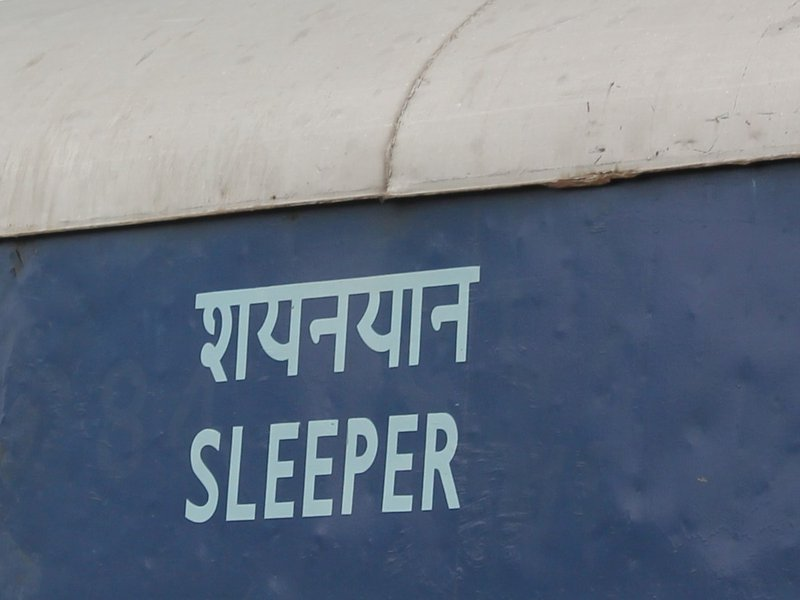
[sample.jpg]


keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다. 이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요.


## 데이터 다운로드(☁️클라우드 유저용)

---

step3에서 심볼릭 링크를 사용한 경우, sample.jpg는 ~/aiffel/ocr/data디렉토리에 있습니다.

## 데이터 준비
---

우측 하단의 Cloud shell을 클릭해서 열어주세요. 아래 명령어를 통해 데이터를 준비합니다.

In [3]:
# ! mkdir -p ~/aiffel/ocr 
# ! cp -rf ~/data ~/aiffel/ocr/data

In [9]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


- 몇 개의 Class가 필요한지 확인하기 위해 다음 셀을 실행한 후 퀴즈를 풀어보세요.

In [10]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [11]:
# $ pip install lmdb

필요한 라이브러리들을 import합니다. 다운로드한 MJ 데이터셋의 위치도 확인해 주세요!

In [12]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


# Recognition model (2) Input Image


데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해 봅시다. 아래의 코드를 실행해 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지, 이미지나 라벨은 어떻게 달려 있는지를 확인해 보도록 합시다.

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


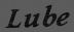

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


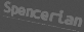

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


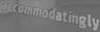

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


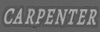

In [13]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

이제부터 lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현하려고 합니다. dataset_path는 읽어들일 데이터셋의 경로입니다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 합니다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

In [14]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


# 17-6. Recognition model (3) Encode
이전 스텝에서 살펴본 바에 의하면, Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다. 그러나 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 이를 해줄 수 있는 LabelConverter 클래스를 작성해 봅시다.

__init__()에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됩니다.
공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.
decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.
입력받은 text를 모델이 학습할 수 있는 label로 만드는 encode() 메소드를 구현해 주세요!
단, 같은 글자가 연속으로 이어지는 경우에는 이어지는 그 사이에 공백 문자의 label을 포함해야 합니다!

OCR 모델 학습데이터에 왜 공백 문자가 포함되어야 하는지는 다음 스텝에서 설명할 예정입니다.

In [15]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
            
         # [[YOUR CODE]]
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)        
        

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보세요!

In [16]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.

# Recognition model (4) Build CRNN model

이제 입력과 출력을 준비했으니 모델을 만들어볼 차례입니다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었습니다.

In [17]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


- 이제, K.ctc_batch_cost()를 활용하여, image_input을 입력으로, 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.

In [18]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


# Recognition model (5) Train & Inference

이제 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다.

In [36]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [38]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
epoch_to_load = 10  # 불러오고 싶은 에폭 번호
checkpoint_path = HOME_DIR + '/model_checkpoint_{:02d}.hdf5'.format(epoch_to_load)

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

In [39]:
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [42]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

# # ModelCheckpoint 설정: 'val_loss'를 모니터링하고, 매 5 에폭마다 모델의 체크포인트 저장
# checkpoint = ModelCheckpoint(checkpoint_path, 
#                              monitor='val_loss', 
#                              save_best_only=False, 
#                              save_weights_only=True, 
#                              save_freq='epoch',
#                              period=5)

'''

TensorFlow 2.x 버전에서 ModelCheckpoint 콜백의 period 파라미터는 더 이상 사용되지 않습니다. 
대신 save_freq 옵션을 사용하여 저장 주기를 설정합니다.

save_freq='epoch' 설정은 매 에폭마다 체크포인트를 저장하도록 지정합니다. 
그러나 period=5 설정은 이와 상충하는데, TensorFlow 2.x에서는 이 옵션이 무시됩니다. 
결과적으로, 이 설정은 매 에폭마다 체크포인트를 저장합니다.

매 5 에폭마다 체크포인트를 저장하려면, save_freq 파라미터에 에폭 횟수를 곱한 배치 수를 지정해야 합니다. 
예를 들어, 매 5 에폭마다 저장하려면 
save_freq=5*steps_per_epoch (여기서 steps_per_epoch는 한 에폭당 배치의 수)로 설정합니다.

'''

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 이전 체크포인트 개수 확인
previous_epochs = 10  # 이미 완료된 에폭 수

# 첫 학습시
# checkpoint_path = HOME_DIR + '/model_checkpoint_{epoch:02d}.hdf5'  

# 추가 학습시
checkpoint_path = HOME_DIR + '/model_checkpoint_{epoch:02d}.hdf5'
checkpoint_path = checkpoint_path.format(epoch=previous_epochs + 1)  # 체크포인트 파일명 업데이트

# ModelCheckpoint 설정: 'val_loss'를 모니터링하고, 매 5 에폭마다 모델의 체크포인트 저장
steps_per_epoch = len(train_set)
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    save_best_only=False, 
    save_weights_only=True, 
    save_freq=5 * steps_per_epoch  # 매 5 에폭마다 저장
)

# EarlyStopping 설정: 'val_loss'를 모니터링
earlystop = EarlyStopping(monitor='val_loss', patience = 5)

# 모델 컴파일
# model.compile(optimizer=Adam(), loss={'ctc': lambda y_true, y_pred: y_pred})

# 모델 학습
history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=10,  # 추가 학습할 에폭 수 지정
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[checkpoint, 
               #earlystop
              ]
)

Epoch 1/10
565/565 [==============================] - 84s 149ms/step - loss: 0.8253 - val_loss: 4.8532
Epoch 2/10
565/565 [==============================] - 86s 151ms/step - loss: 0.6472 - val_loss: 5.1905
Epoch 3/10
565/565 [==============================] - 85s 150ms/step - loss: 0.5275 - val_loss: 5.2650
Epoch 4/10
565/565 [==============================] - 85s 150ms/step - loss: 0.4339 - val_loss: 5.3858
Epoch 5/10
565/565 [==============================] - 85s 150ms/step - loss: 0.3629 - val_loss: 5.5482
Epoch 6/10
565/565 [==============================] - 85s 151ms/step - loss: 0.3090 - val_loss: 5.9234
Epoch 7/10
565/565 [==============================] - 85s 150ms/step - loss: 0.2682 - val_loss: 5.7853
Epoch 8/10
565/565 [==============================] - 85s 150ms/step - loss: 0.2343 - val_loss: 5.9100
Epoch 9/10
565/565 [==============================] - 85s 151ms/step - loss: 0.2068 - val_loss: 6.1209
Epoch 10/10
565/565 [==============================] - 85s 150ms/step - l

In [55]:
import pickle

def save_history(history, filename):
    with open(filename, 'wb') as file_pi:
        pickle.dump(history, file_pi)

def load_history(filename):
    with open(filename, 'rb') as file_pi:
        history = pickle.load(file_pi)
    return history

In [52]:
def combine_histories(old_history, new_history):
    for key in old_history.keys():
        old_history[key].extend(new_history.history[key])  # 수정된 부분
    return old_history

In [49]:
# 히스토리 불러오기
loaded_history = load_history('training_history.pkl')

In [53]:
# 기존 히스토리와 새 히스토리 결합
combined_history = combine_histories(loaded_history, history)

In [56]:
# 히스토리 저장
save_history(combined_history, 'training_history.pkl')

이제 학습된 모델을 테스트셋을 통해 확인해 볼 차례입니다.

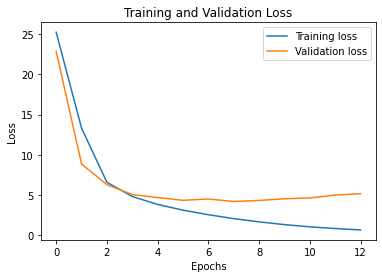

In [21]:
import matplotlib.pyplot as plt

# 히스토리 불러오기
loaded_history = load_history('training_history.pkl')

# 훈련 및 검증 손실 시각화
plt.figure()
plt.plot(loaded_history['loss'], label='Training loss')
plt.plot(loaded_history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 시각화 (정확도가 기록된 경우)
# plt.figure()
# plt.plot(loaded_history['accuracy'], label='Training accuracy')
# plt.plot(loaded_history['val_accuracy'], label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

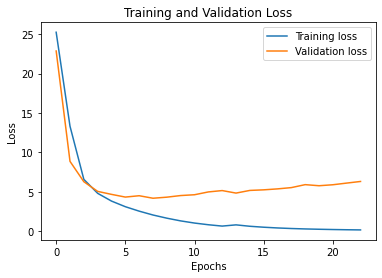

In [57]:
# 추가 학습 
import matplotlib.pyplot as plt

# 히스토리 불러오기
loaded_history = load_history('training_history.pkl')

# 훈련 및 검증 손실 시각화
plt.figure()
plt.plot(loaded_history['loss'], label='Training loss')
plt.plot(loaded_history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 시각화 (정확도가 기록된 경우)
# plt.figure()
# plt.plot(loaded_history['accuracy'], label='Training accuracy')
# plt.plot(loaded_history['val_accuracy'], label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [58]:
# 에폭 10번 모델
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
epoch_to_load = 10  # 불러오고 싶은 에폭 번호
checkpoint_path = HOME_DIR + '/model_checkpoint_{:02d}.hdf5'.format(epoch_to_load)

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_10 = build_crnn_model()
model_10.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model_10.get_layer('input_image').output
y_pred = model_10.get_layer('output').output
model_pred_10 = Model(inputs=input_data, outputs=y_pred)

In [64]:
# 에폭 20번 모델
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
epoch_to_load = 11  # 불러오고 싶은 에폭 번호
checkpoint_path = HOME_DIR + '/model_checkpoint_{:02d}.hdf5'.format(epoch_to_load)

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model_20 = build_crnn_model()
model_20.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model_20.get_layer('input_image').output
y_pred = model_20.get_layer('output').output
model_pred_20 = Model(inputs=input_data, outputs=y_pred)

학습된 모델의 성능을 눈으로 확인해봅시다.

In [60]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 SLINKING9999999999999999


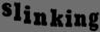

Result: 	 ALEPPO99999999999999999


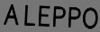

Result: 	 TWBNDA999999999999999999


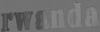

Result: 	 NATHANS99999999999999999


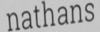

Result: 	 HALLEO99999999999999999


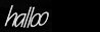

Result: 	 HURLS9999999999999999999


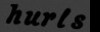

Result: 	 DOWNSIZE9999999999999999


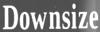

Result: 	 ROBOTIC99999999999999999


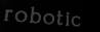

Result: 	 SLOPPY99999999999999999


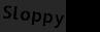

Result: 	 HERMITE99999999999999999


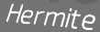

In [61]:
# 모델 에폭 10번
check_inference(model_pred_10, test_set, index=10)

Result: 	 SLINKING9999999999999999


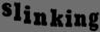

Result: 	 ALEPPO99999999999999999


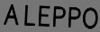

Result: 	 RWANDA999999999999999999


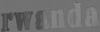

Result: 	 NATHANS99999999999999999


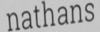

Result: 	 HALLEO99999999999999999


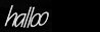

Result: 	 HURLS9999999999999999999


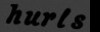

Result: 	 DOWNSIZE9999999999999999


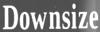

Result: 	 ROBOTIC99999999999999999


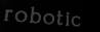

Result: 	 SLOPPY99999999999999999


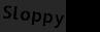

Result: 	 HERMITE99999999999999999


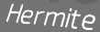

In [65]:
# 모델 에폭 20번
check_inference(model_pred_20, test_set, index=10)

- 오 결과가 썩 나쁘지 않은 것 같은데.. 희망을 품고 프로젝트로 넘어가 보겠습니다.

# 프로젝트 시작

- 이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 단어의 영역을 잘라오도록 해주세요.

In [24]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = '/aiffel/aiffel/ocr' + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [68]:
# 이번 프로젝트용 샘플 이미지로 inference

from PIL import Image, ImageDraw
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    
    # img to pil
    img_pil = Image.open(img_path)
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    
    # img to tensor
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = img[tf.newaxis, :, :, :]
    
    # detector
    det_result = detector.detect(img.numpy())

    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

- 이제 위에서 이미지 내의 단어 이미지를 얻었습니다. 그럼 Recognition model로 인식하는 함수를 직접 작성하고 그 결과를 출력해보세요!

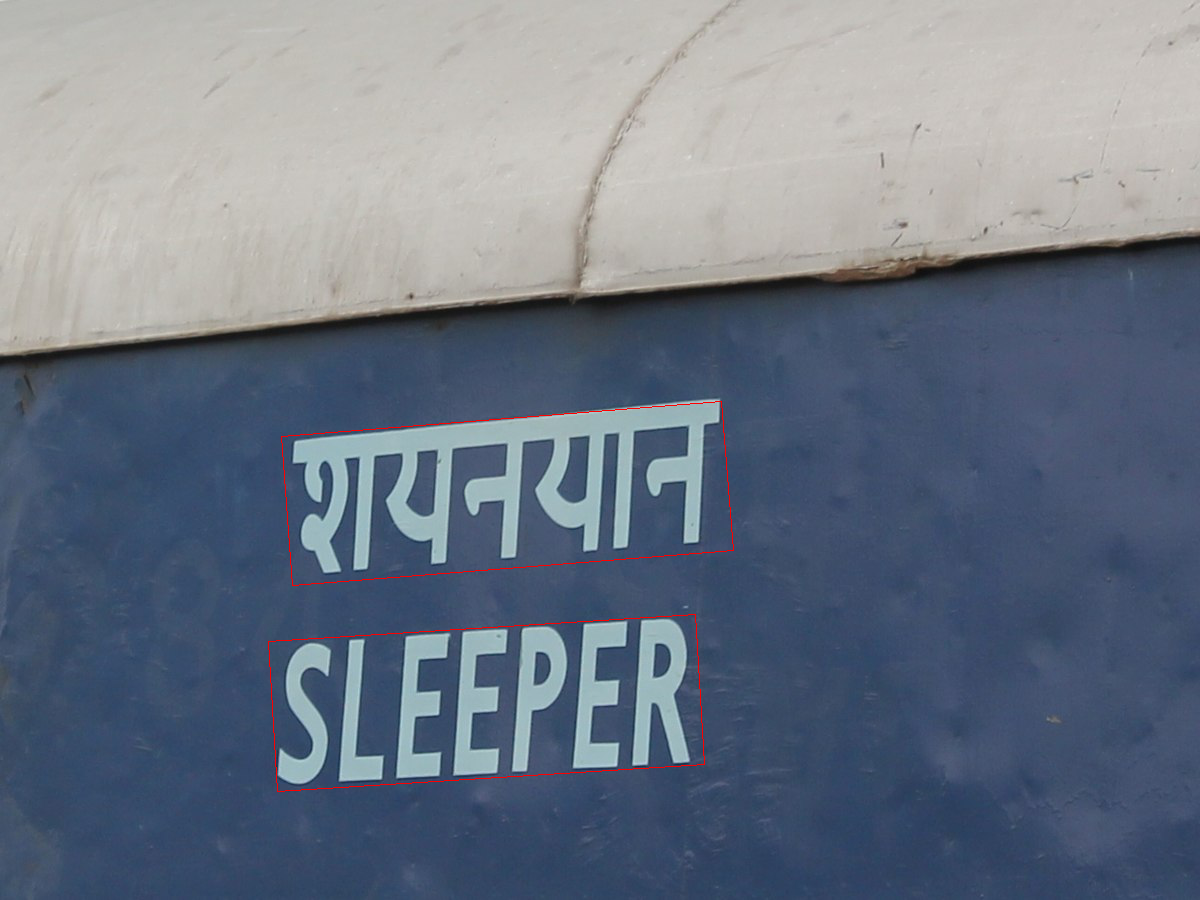

In [69]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

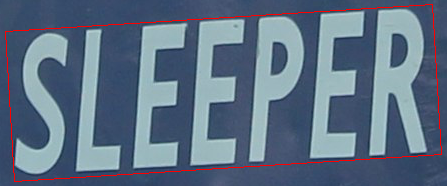

In [70]:
display(cropped_img[1])

In [71]:
def recognize_img(pil_img, model_pred, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    
    # pil to numpy
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    
    # detect -> recognition
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))
    

Result: 	 RTUFRIET9999999999999999


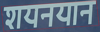

Result: 	 SLEEPER9999999999999999


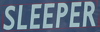

In [72]:
for _img in cropped_img:
    recognize_img(_img, model_pred_10)

Result: 	 RTUARIND9999999999999999


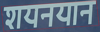

Result: 	 SLEEPER9999999999999999


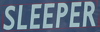

In [73]:
for _img in cropped_img:
    recognize_img(_img, model_pred_20)

평가문항	
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.	
상세기준 : 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.


2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.	
상세기준 : 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.


3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.	  
상세기준 : 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

## 회고록
- 이번 프로젝트는 이미지 속에서 글자를 찾고 글자를 읽어내는 OCR 과정이었습니다.
- 배운점 : 광학 문자 인식에 대해 배웠습니다.
- 느낀점 : 어려운 기술이구나 구현하기 어렵다. 이해하기 아주 어렵다..
- 아쉬운 점 : 이해하지 못하는 저 자신이 아쉽습니다.